## Preparation

In [ ]:
from google.colab import drive
import zipfile
import os

# Google Drive mount
drive.mount('/content/drive')

# Update these paths according to where the zip file is located in your Google Drive
GOOGLE_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset'  # Path to the folder containing the zip file
ZIP_FILE_NAME = 'snli_1.0.zip'  # Name of the zip file
DATA_DIR = 'data'  # Directory where you want to extract the dataset

def extract_from_drive(drive_path, zip_file_name, data_dir):
    zip_file_path = os.path.join(drive_path, zip_file_name)
    print("Extracting ...")
    with zipfile.ZipFile(zip_file_path) as zip_ref:
        zip_ref.extractall(data_dir)
    print("Completed!")

# Create the DATA_DIR if it doesn't exist
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Extract data
extract_from_drive(GOOGLE_DRIVE_PATH, ZIP_FILE_NAME, DATA_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting ...
Completed!


The dataset comes in two formats (tsv and json) and has already been split into train/dev/test.

In [ ]:

snli_folder = os.path.join(DATA_DIR, "snli_1.0")
os.listdir(snli_folder)

['snli_1.0_train.jsonl',
 'snli_1.0_dev.txt',
 'snli_1.0_train.txt',
 'snli_1.0_test.txt',
 'snli_1.0_dev.jsonl',
 'snli_1.0_test.jsonl',
 'Icon\r',
 '.DS_Store',
 'README.txt']

From the training set, read 500 (gold_label, sentence1, sentence2) triplets and store them in an array somewhere. You can randomly sample them from the entire training dataset, ensuring you have a sample with a decent number of neutral, entailment, and contradiction labels.

In [ ]:
import pandas as pd
train_path =  os.path.join(snli_folder, "snli_1.0_train.txt")
dev_path = os.path.join(snli_folder, "snli_1.0_dev.txt")
test_path = os.path.join(snli_folder, "snli_1.0_test.txt")

# Read the dataset
df_train = pd.read_csv(train_path, sep='\t')

# Drop rows where gold_label is NaN or '-', which might occur in the dataset
df_train = df_train[df_train['gold_label'].isin(['neutral', 'entailment', 'contradiction'])]

# Sample rows from each label group
sample_size = 500  # Total sample size
labels = df_train['gold_label'].unique()
samples_per_label = sample_size // len(labels)

samples = []
extra_samples_needed = sample_size % len(labels)

for label in labels:
    n_samples = samples_per_label + (1 if extra_samples_needed > 0 else 0)
    extra_samples_needed -= 1
    samples.append(df_train[df_train['gold_label'] == label].sample(n=n_samples, random_state=1))

# Concatenate samples and shuffle
df_sample = pd.concat(samples).sample(frac=1, random_state=1).reset_index(drop=True)

# If the total number exceeds 500, randomly drop the extra samples
if len(df_sample) > sample_size:
    df_sample = df_sample.sample(n=sample_size, random_state=1).reset_index(drop=True)


Load the GPT2 language model and tokenizer using Huggingface’s Transformers, using GPT2LMHeadModel when loading the model itself.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np

import logging
logging.getLogger().setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = model.to(device)
print(model)

cuda
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


## Define which layer to probe: h.0.mlp/h.5.mlp/h.9.mlp and define which prompt to use

In [ ]:
# PROBING_LAYER = "h0.mlp"
# PROBING_LAYER = "h5.mlp"
PROBING_LAYER = "h9.mlp"
# PROMPT = "This conveys a similar message as this:"
PROMPT = "This has the same meaning as:"

## Obtain Internal States


Before probing the model, I need to first transform your dataset into prompts. For every (gold_label, sentence1, sentence2) triplet in the dataset, I combine sentence1 and sentence2 such that the two sentences in each data item are connected in a single string, like so:

combined_sentences = “\<sentence1\> This has the same meaning as: \<sentence2\>”
Such that now I have a dataset of 500 (gold_label, sentence1, sentence2, combined_sentences) tuples.

In [ ]:
# Create the combined_sentences column in the df_sample DataFrame
df_sample['combined_sentences'] = df_sample.apply(
    lambda row: f"{row['sentence1']} {PROMPT} {row['sentence2']}",
    axis=1
)
# Extract the required columns
sampled_data = df_sample[['gold_label', 'sentence1', 'sentence2', 'combined_sentences']]

# Convert to array or list for further use
quadruple_array = sampled_data.values

print(len(quadruple_array))
print(quadruple_array[:5, :])

500
[['contradiction'
  'People crossing a river on a narrow wooden bridge from one side to the other at sunset.'
  'People are sitting on a bridge.'
  'People crossing a river on a narrow wooden bridge from one side to the other at sunset. This has the same meaning as: People are sitting on a bridge.']
 ['entailment' 'two men in a ring getting ready to fight.'
  'Two racelers were ready for fight.'
  'two men in a ring getting ready to fight. This has the same meaning as: Two racelers were ready for fight.']
 ['neutral' 'A woman walking with a beverage in her right hand.'
  'A woman enjoys a beer.'
  'A woman walking with a beverage in her right hand. This has the same meaning as: A woman enjoys a beer.']
 ['neutral'
  'A martial artist pins her opponent by sitting on her shoulders.'
  'A martial artist fighting to win'
  'A martial artist pins her opponent by sitting on her shoulders. This has the same meaning as: A martial artist fighting to win']
 ['entailment'
  'A man in dark clo

In [ ]:
%pip install git+https://github.com/davidbau/baukit

  Cloning https://github.com/davidbau/baukit to /tmp/pip-req-build-ly3bp8bp
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit /tmp/pip-req-build-ly3bp8bp
  Resolved https://github.com/davidbau/baukit to commit 5e23007c02fd58f063200c5dc9033e90f092630d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


Get number of tokens in the second sentence for each entry in the dataset

In [ ]:
def extract_second_sentence_len(array):
    # This function extracts the second sentence from each element in the array
    return [len(sentence.split(f"{PROMPT} ")[1]) for sentence in array]

In [ ]:
combined_tmp = quadruple_array[:,3]
combined_second_sentence_lens = extract_second_sentence_len(combined_tmp)
combined_second_sentences = []
for i in range(len(combined_tmp)):
  combined_second_sentences.append(combined_tmp[i][-combined_second_sentence_lens[i]:])
print(combined_second_sentences)

['People are sitting on a bridge.', 'Two racelers were ready for fight.', 'A woman enjoys a beer.', 'A martial artist fighting to win', 'A man is looking through a telescope.', 'An African American woman helping another woman.', 'Two men are fighting.', 'Tables are being prepared for movie stars at a fancy restaurant.', 'the bags are not arriving', 'Two kids are swinging at the park with their friends.', 'There are people sitting.', 'A woman plays solitaire.', 'A man in a white shirt is standing in front of a tire shop.', 'A bicyclist doing his best not to fall.', 'A man stand near bottles and a cat.', 'A man is running away with a sign.', 'The woman is playing tennis.', 'A man is sitting on a bench.', 'The people are inside the church', 'A man poses in front of the statue he made.', 'The two men are having a BBQ party.', 'A boy kisses his mother hello before he starts school.', 'A garbage truck is picking up the dumpster.', 'two men playing sports', 'Two dogs are running to chase a ca

For each data item, obtain a tensor of shape torch.Size([1, num_tokens_sentence2, 768]), where num_tokens equals the number of tokens in combined_sentences.

In [ ]:
combined_tmp = quadruple_array[:,3]
hidden_states = []
layer_name = ""
if PROBING_LAYER == "h0.mlp":
  layer_name = "transformer.h.0.mlp"
elif PROBING_LAYER == "h5.mlp":
  layer_name = "transformer.h.5.mlp"
elif PROBING_LAYER == "h9.mlp":
  layer_name = "transformer.h.9.mlp"

from baukit import Trace
with Trace(model, layer_name) as ret:
  for i in range(len(combined_tmp)):
    combined_tmp_tens = torch.tensor(tokenizer.encode(combined_tmp[i])).unsqueeze(0).to(device)
    _ = model(combined_tmp_tens)
    representation = ret.output
    hidden_states.append(representation)
modified_second_sentence_hidden = []
for i in range(len(hidden_states)):
  modified_second_sentence_hidden.append(hidden_states[i][:,-combined_second_sentence_lens[i]:,:])

modified_second_sentence_hidden = [entry.cpu().detach().numpy() for entry in modified_second_sentence_hidden]

Store the items into a pickle object in the Google Drive.

In [ ]:
import pickle
GENERATED_DB_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/generated_db'
def storeData():
    # initializing data to be stored in db
    sampled_data["hidden_states"] = pd.Series(modified_second_sentence_hidden)
    db = sampled_data[['gold_label', 'sentence1', 'sentence2', 'hidden_states']]
    print(db)
    dbfile = open(GENERATED_DB_PATH, 'ab')
    # source, destination
    pickle.dump(db, dbfile)
    dbfile.close()

def loadData():
    # for reading also binary mode is important
    dbfile = open(GENERATED_DB_PATH, 'rb')
    db = pickle.load(dbfile)
    print(db)
    dbfile.close()
    return db

In [ ]:
# store the dataset into Google drive
storeData()

        gold_label                                          sentence1  \
0    contradiction  People crossing a river on a narrow wooden bri...   
1       entailment          two men in a ring getting ready to fight.   
2          neutral  A woman walking with a beverage in her right h...   
3          neutral  A martial artist pins her opponent by sitting ...   
4       entailment  A man in dark clothes uses a tourist telescope...   
..             ...                                                ...   
495  contradiction            Someone is preparing some kind of food.   
496        neutral  A group of five men are standing in the middle...   
497     entailment  A person is in the air while riding his bicycl...   
498  contradiction  An orange and white motorcycle is being ridden...   
499        neutral  Two excited men standing in front of very larg...   

                                           sentence2  \
0                    People are sitting on a bridge.   
1          

## Training a Classifier

### **My classifier (Attention Pooling Classifier similar to the one in paper: Self-Attention Encoding and Pooling for Speaker Recognition)**


In [ ]:
# Hyper parameters
BATCH_SIZE = 4
dm = 768
# hidden_size_1 = 16
# hidden_size_2 = 4
num_classes = 3
num_epochs = 50


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class DNN(nn.Module):
#     def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
#         super(DNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size_1)
#         self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
#         self.fc3 = nn.Linear(hidden_size_2, num_classes)
#         self.dropout = nn.Dropout(p=0.05)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc3(x))
#         x = self.dropout(x)
#         return x

class DNNSingleLayer(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNNSingleLayer, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        self.dropout = nn.Dropout(p=0.05)

    def forward(self, x):
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = F.softmax(x, dim=1)
        return x

class AttentionPooling(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionPooling, self).__init__()
        # Initialize the trainable weight parameter W_c with the appropriate shape
        # feature_dim corresponds to dm in the equation
        self.W_c = nn.Parameter(torch.randn(feature_dim))

    def forward(self, H):
        # H is the sequence of encoded features with shape (batch_size, T, dm)
        # W_c is the trainable parameter with shape (dm,)
        # We need to expand W_c to match the batch size and perform batch matrix multiplication

        # First, we expand W_c to (batch_size, 1, dm) to perform bmm with H.transpose(1, 2) which is (batch_size, dm, T)
        batch_size, T, dm = H.size()
        W_c_expanded = self.W_c.expand(batch_size, dm).unsqueeze(1)

        # Calculate compatibility scores using batched matrix multiplication (bmm)
        compatibility = torch.bmm(W_c_expanded, H.transpose(1, 2))  # Shape: (batch_size, 1, T)

        # Squeeze to remove the second dimension and apply softmax to get attention weights
        # Now it's (batch_size, T)
        attention_weights = F.softmax(compatibility.squeeze(1), dim=-1)

        # Calculate the segment-level representation as a weighted sum of H
        # We expand attention_weights to (batch_size, 1, T) and perform bmm with H (batch_size, T, dm)
        C = torch.bmm(attention_weights.unsqueeze(1), H).squeeze(1) # Shape: (batch_size, dm)
        return C

class CombinedNetwork(nn.Module):
    def __init__(self, dm, num_classes):
        super(CombinedNetwork, self).__init__()
        self.attention_pooling = AttentionPooling(dm)
        # self.dnn_classifier = DNN(dm, hidden_size_1, hidden_size_2, num_classes)
        self.dnn_classifier = DNNSingleLayer(dm, num_classes)

    def forward(self, x):
        # Apply attention pooling to the input sequence
        pooled_representation = self.attention_pooling(x)
        # Feed the result into the DNN classifier
        class_probabilities = self.dnn_classifier(pooled_representation)
        return class_probabilities



In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, dataframe, max_len=None):
        self.dataframe = dataframe
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(dataframe['gold_label'])
        self.hidden_states = dataframe['hidden_states']
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.labels[idx]
        hidden_state = self.hidden_states.iloc[idx]
        hidden_state = hidden_state.squeeze(0)

        # Handle variable lengths
        if self.max_len is not None:
            # Truncate or pad the sequence
            if hidden_state.shape[0] >= self.max_len:
                hidden_state = torch.from_numpy(hidden_state[:self.max_len, :])
            elif hidden_state.shape[0] < self.max_len:
                padding = torch.zeros(self.max_len - hidden_state.shape[0], hidden_state.shape[1])
                hidden_state = torch.cat((torch.from_numpy(hidden_state), padding), dim=0)

        return hidden_state, label

df = loadData()
train_df, test_df = train_test_split(df, test_size=0.3, random_state=1)  # 70% training, 30% for test+validation
validation_df, test_df = train_test_split(test_df, test_size=0.5, random_state=1)  # Split the 30% into half for validation and test

max_len = df['hidden_states'].apply(lambda x: x.shape[1]).max()
print(max_len)
# Create the dataset
dataset = CustomDataset(df, max_len=max_len)

# Example of using DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for hidden_states, labels in dataloader:
    print(hidden_states.shape, labels)

        gold_label                                          sentence1  \
0    contradiction  People crossing a river on a narrow wooden bri...   
1       entailment          two men in a ring getting ready to fight.   
2          neutral  A woman walking with a beverage in her right h...   
3          neutral  A martial artist pins her opponent by sitting ...   
4       entailment  A man in dark clothes uses a tourist telescope...   
..             ...                                                ...   
495  contradiction            Someone is preparing some kind of food.   
496        neutral  A group of five men are standing in the middle...   
497     entailment  A person is in the air while riding his bicycl...   
498  contradiction  An orange and white motorcycle is being ridden...   
499        neutral  Two excited men standing in front of very larg...   

                                           sentence2  \
0                    People are sitting on a bridge.   
1          

In [ ]:
from torch.optim import Adam, SGD

train_dataset = CustomDataset(train_df, max_len=max_len)
validation_dataset = CustomDataset(validation_df, max_len=max_len)
test_dataset = CustomDataset(test_df, max_len=max_len)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Since the colab does not have sufficient GPU memory for training. We have to run the code for h0, h5, h9, seperately. Change the global variable defined in section "Define which layer we want to probe: h.0.mlp/h.5.mlp/h.9.mlp" to run different probing.

### Layer.h.0.mlp

In [ ]:
if PROBING_LAYER == "h0.mlp" and PROMPT == "This has the same meaning as:":
  # Initialize the network, criterion, and optimizer as before

  train_losses, validation_losses = [], []
  best_val_loss = float('inf')
  best_model_path = 'best_model.pth'
  T = max_len
  network = CombinedNetwork(dm, num_classes)
  network.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = Adam(network.parameters(), lr=0.00001)
  for epoch in range(num_epochs):
      network.train()
      total_loss = 0
      total_val_loss = 0
      for hidden_states, labels in train_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          outputs = network(input)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_train_loss = total_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      network.eval()
      total_loss = 0
      with torch.no_grad():
          for hidden_states, labels in validation_loader:
              input = hidden_states.to(device)
              target = labels.to(device)
              outputs = network(input)
              loss = criterion(outputs, target)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(validation_loader)
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(network.state_dict(), best_model_path)

      validation_losses.append(avg_val_loss)

      print(f'h0.mlp Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

print(f'h0.mlp, best validation loss {best_val_loss}')

h0.mlp Epoch [1/50], Train Loss: 1.1057, Validation Loss: 1.0988
h0.mlp Epoch [2/50], Train Loss: 1.0992, Validation Loss: 1.0984
h0.mlp Epoch [3/50], Train Loss: 1.0893, Validation Loss: 1.0951
h0.mlp Epoch [4/50], Train Loss: 1.0759, Validation Loss: 1.0906
h0.mlp Epoch [5/50], Train Loss: 1.0671, Validation Loss: 1.0876
h0.mlp Epoch [6/50], Train Loss: 1.0569, Validation Loss: 1.0822
h0.mlp Epoch [7/50], Train Loss: 1.0449, Validation Loss: 1.0773
h0.mlp Epoch [8/50], Train Loss: 1.0338, Validation Loss: 1.0739
h0.mlp Epoch [9/50], Train Loss: 1.0275, Validation Loss: 1.0715
h0.mlp Epoch [10/50], Train Loss: 1.0164, Validation Loss: 1.0702
h0.mlp Epoch [11/50], Train Loss: 1.0140, Validation Loss: 1.0695
h0.mlp Epoch [12/50], Train Loss: 1.0035, Validation Loss: 1.0694
h0.mlp Epoch [13/50], Train Loss: 0.9960, Validation Loss: 1.0693
h0.mlp Epoch [14/50], Train Loss: 0.9901, Validation Loss: 1.0685
h0.mlp Epoch [15/50], Train Loss: 0.9874, Validation Loss: 1.0678
h0.mlp Epoch [16/50

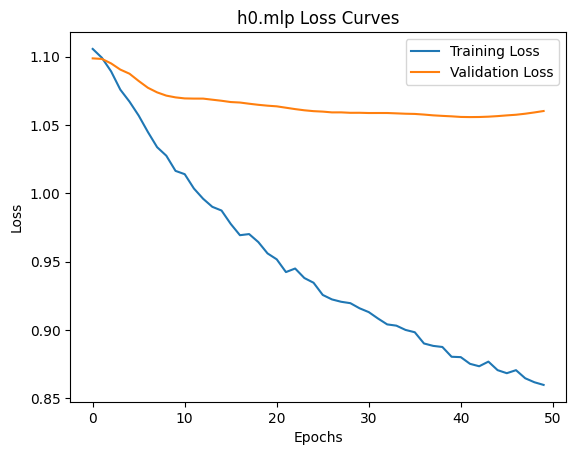

In [ ]:
if PROBING_LAYER == "h0.mlp" and PROMPT == "This has the same meaning as:":
  import matplotlib.pyplot as plt

  plt.plot(train_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.title('h0.mlp Loss Curves')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
if PROBING_LAYER == "h0.mlp" and PROMPT == "This has the same meaning as:":
  network.eval()  # Set the network to evaluation mode
  total_errors = 0
  total_samples = 0
  network.load_state_dict(torch.load(best_model_path))

  with torch.no_grad():
      for hidden_states, labels in test_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          # Forward pass
          outputs = network(input)

          # Get predictions from the maximum value
          _, predicted = torch.max(outputs.data, 1)
          print(predicted)

          total_errors += (predicted != target).sum().item()
          total_samples += target.size(0)

  error_rate = total_errors / total_samples

  print(f'h0.mlp Test Error Rate: {error_rate:.4f}')

tensor([2, 0, 1, 0], device='cuda:0')
tensor([1, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 1], device='cuda:0')
tensor([2, 1, 0, 2], device='cuda:0')
tensor([1, 2, 2, 2], device='cuda:0')
tensor([1, 2, 0, 2], device='cuda:0')
tensor([0, 2, 0, 0], device='cuda:0')
tensor([2, 2, 2, 0], device='cuda:0')
tensor([1, 1, 0, 2], device='cuda:0')
tensor([2, 1, 2, 0], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([1, 2, 2, 2], device='cuda:0')
tensor([2, 0, 2, 2], device='cuda:0')
tensor([1, 2, 2, 1], device='cuda:0')
tensor([2, 0, 2, 2], device='cuda:0')
tensor([2, 2, 2, 0], device='cuda:0')
tensor([2, 0, 0, 2], device='cuda:0')
tensor([2, 1, 0, 2], device='cuda:0')
tensor([1, 2, 1], device='cuda:0')
h0.mlp Test Error Rate: 0.7200


## Probe other layers

###Layer.h.05.mlp


In [ ]:
if PROBING_LAYER == "h5.mlp" and PROMPT == "This has the same meaning as:":
  # Initialize the network, criterion, and optimizer as before

  train_losses, validation_losses = [], []
  best_val_loss = float('inf')
  best_model_path = 'best_model.pth'
  T = max_len
  network = CombinedNetwork(dm, num_classes)
  network.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = Adam(network.parameters(), lr=0.00001)
  for epoch in range(num_epochs):
      network.train()
      total_loss = 0
      total_val_loss = 0
      for hidden_states, labels in train_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          outputs = network(input)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_train_loss = total_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      network.eval()
      total_loss = 0
      with torch.no_grad():
          for hidden_states, labels in validation_loader:
              input = hidden_states.to(device)
              target = labels.to(device)
              outputs = network(input)
              loss = criterion(outputs, target)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(validation_loader)
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(network.state_dict(), best_model_path)

      validation_losses.append(avg_val_loss)

      print(f'h5.mlp Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

print(f'h5.mlp, best validation loss {best_val_loss}')

h5.mlp Epoch [1/50], Train Loss: 1.1084, Validation Loss: 1.1101
h5.mlp Epoch [2/50], Train Loss: 1.0943, Validation Loss: 1.1029
h5.mlp Epoch [3/50], Train Loss: 1.0815, Validation Loss: 1.0982
h5.mlp Epoch [4/50], Train Loss: 1.0747, Validation Loss: 1.0940
h5.mlp Epoch [5/50], Train Loss: 1.0691, Validation Loss: 1.0902
h5.mlp Epoch [6/50], Train Loss: 1.0555, Validation Loss: 1.0905
h5.mlp Epoch [7/50], Train Loss: 1.0488, Validation Loss: 1.0884
h5.mlp Epoch [8/50], Train Loss: 1.0393, Validation Loss: 1.0855
h5.mlp Epoch [9/50], Train Loss: 1.0281, Validation Loss: 1.0816
h5.mlp Epoch [10/50], Train Loss: 1.0186, Validation Loss: 1.0809
h5.mlp Epoch [11/50], Train Loss: 1.0100, Validation Loss: 1.0810
h5.mlp Epoch [12/50], Train Loss: 1.0024, Validation Loss: 1.0823
h5.mlp Epoch [13/50], Train Loss: 0.9954, Validation Loss: 1.0837
h5.mlp Epoch [14/50], Train Loss: 0.9920, Validation Loss: 1.0840
h5.mlp Epoch [15/50], Train Loss: 0.9879, Validation Loss: 1.0815
h5.mlp Epoch [16/50

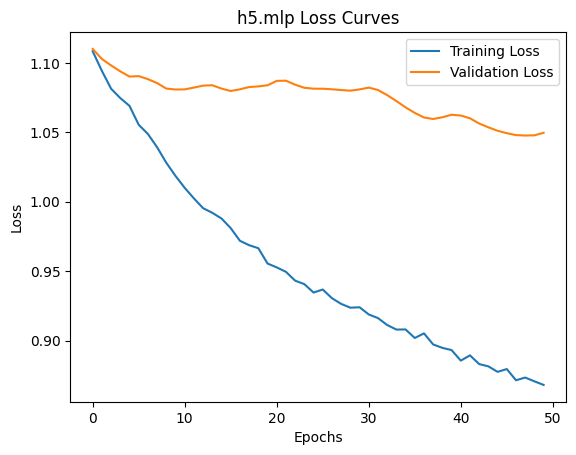

In [ ]:
if PROBING_LAYER == "h5.mlp" and PROMPT == "This has the same meaning as:":
  import matplotlib.pyplot as plt

  plt.plot(train_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.title('h5.mlp Loss Curves')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
if PROBING_LAYER == "h5.mlp" and PROMPT == "This has the same meaning as:":
  network.eval()  # Set the network to evaluation mode
  total_errors = 0
  total_samples = 0
  network.load_state_dict(torch.load(best_model_path))

  with torch.no_grad():
      for hidden_states, labels in test_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          # Forward pass
          outputs = network(input)

          # Get predictions from the maximum value
          _, predicted = torch.max(outputs.data, 1)
          print(predicted)

          total_errors += (predicted != target).sum().item()
          total_samples += target.size(0)

  error_rate = total_errors / total_samples

  print(f'h5.mlp Test Error Rate: {error_rate:.4f}')

tensor([1, 2, 1, 0], device='cuda:0')
tensor([2, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 2, 2, 1], device='cuda:0')
tensor([1, 1, 1, 2], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 2, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 2, 0], device='cuda:0')
tensor([1, 0, 2, 1], device='cuda:0')
tensor([0, 2, 1, 1], device='cuda:0')
tensor([2, 1, 1], device='cuda:0')
h5.mlp Test Error Rate: 0.6000


### Layer h.09.mlp

In [ ]:
if PROBING_LAYER == "h9.mlp" and PROMPT == "This has the same meaning as:":
 # Initialize the network, criterion, and optimizer as before

  train_losses, validation_losses = [], []
  best_val_loss = float('inf')
  best_model_path = 'best_model.pth'
  T = max_len
  network = CombinedNetwork(dm, num_classes)
  network.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = Adam(network.parameters(), lr=0.00001)
  for epoch in range(num_epochs):
      network.train()
      total_loss = 0
      total_val_loss = 0
      for hidden_states, labels in train_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          outputs = network(input)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_train_loss = total_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      network.eval()
      total_loss = 0
      with torch.no_grad():
          for hidden_states, labels in validation_loader:
              input = hidden_states.to(device)
              target = labels.to(device)
              outputs = network(input)
              loss = criterion(outputs, target)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(validation_loader)
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(network.state_dict(), best_model_path)

      validation_losses.append(avg_val_loss)

      print(f'h9.mlp Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

print(f'h9.mlp, best validation loss {best_val_loss}')

h9.mlp Epoch [1/50], Train Loss: 1.1003, Validation Loss: 1.0950
h9.mlp Epoch [2/50], Train Loss: 1.1012, Validation Loss: 1.0968
h9.mlp Epoch [3/50], Train Loss: 1.0894, Validation Loss: 1.0968
h9.mlp Epoch [4/50], Train Loss: 1.0905, Validation Loss: 1.0960
h9.mlp Epoch [5/50], Train Loss: 1.0866, Validation Loss: 1.0947
h9.mlp Epoch [6/50], Train Loss: 1.0827, Validation Loss: 1.0926
h9.mlp Epoch [7/50], Train Loss: 1.0765, Validation Loss: 1.0893
h9.mlp Epoch [8/50], Train Loss: 1.0787, Validation Loss: 1.0866
h9.mlp Epoch [9/50], Train Loss: 1.0728, Validation Loss: 1.0845
h9.mlp Epoch [10/50], Train Loss: 1.0707, Validation Loss: 1.0832
h9.mlp Epoch [11/50], Train Loss: 1.0701, Validation Loss: 1.0826
h9.mlp Epoch [12/50], Train Loss: 1.0653, Validation Loss: 1.0819
h9.mlp Epoch [13/50], Train Loss: 1.0652, Validation Loss: 1.0816
h9.mlp Epoch [14/50], Train Loss: 1.0651, Validation Loss: 1.0810
h9.mlp Epoch [15/50], Train Loss: 1.0596, Validation Loss: 1.0813
h9.mlp Epoch [16/50

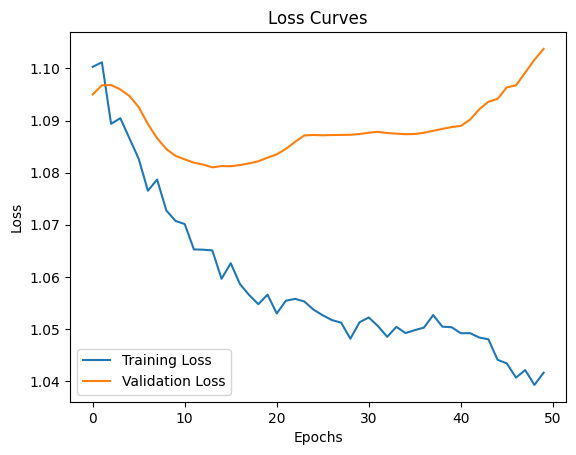

In [ ]:
if PROBING_LAYER == "h9.mlp" and PROMPT == "This has the same meaning as:":
  import matplotlib.pyplot as plt
  plt.plot(train_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.title('Loss Curves')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
if PROBING_LAYER == "h9.mlp" and PROMPT == "This has the same meaning as:":
  network.eval()  # Set the network to evaluation mode
  total_errors = 0
  total_samples = 0
  network.load_state_dict(torch.load(best_model_path))

  with torch.no_grad():
      for hidden_states, labels in test_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          # Forward pass
          outputs = network(input)

          # Get predictions from the maximum value
          _, predicted = torch.max(outputs.data, 1)
          print(predicted)

          total_errors += (predicted != target).sum().item()
          total_samples += target.size(0)

  error_rate = total_errors / total_samples

  print(f'h9.mlp Test Error Rate: {error_rate:.4f}')

tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 1], device='cuda:0')
tensor([0, 1, 0, 0], device='cuda:0')
tensor([0, 1, 0, 0], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 0, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 1], device='cuda:0')
tensor([1, 0, 0], device='cuda:0')
Test Error Rate: 0.6267


## Trying difference prompts and compare performance


### Layer.h.0.mlp

In [ ]:
if PROBING_LAYER == "h0.mlp" and PROMPT == "This conveys a similar message as this:":
  # Initialize the network, criterion, and optimizer as before

  train_losses, validation_losses = [], []
  best_val_loss = float('inf')
  best_model_path = 'best_model.pth'
  T = max_len
  network = CombinedNetwork(dm, num_classes)
  network.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = Adam(network.parameters(), lr=0.00001)
  for epoch in range(num_epochs):
      network.train()
      total_loss = 0
      total_val_loss = 0
      for hidden_states, labels in train_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          outputs = network(input)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_train_loss = total_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      network.eval()
      total_loss = 0
      with torch.no_grad():
          for hidden_states, labels in validation_loader:
              input = hidden_states.to(device)
              target = labels.to(device)
              outputs = network(input)
              loss = criterion(outputs, target)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(validation_loader)
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(network.state_dict(), best_model_path)

      validation_losses.append(avg_val_loss)

      print(f'h0.mlp Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

print(f'h0.mlp, best validation loss {best_val_loss}')

h0.mlp Epoch [1/50], Train Loss: 1.1139, Validation Loss: 1.1107
h0.mlp Epoch [2/50], Train Loss: 1.1014, Validation Loss: 1.1054
h0.mlp Epoch [3/50], Train Loss: 1.0898, Validation Loss: 1.1051
h0.mlp Epoch [4/50], Train Loss: 1.0819, Validation Loss: 1.1025
h0.mlp Epoch [5/50], Train Loss: 1.0679, Validation Loss: 1.1014
h0.mlp Epoch [6/50], Train Loss: 1.0571, Validation Loss: 1.1029
h0.mlp Epoch [7/50], Train Loss: 1.0451, Validation Loss: 1.1027
h0.mlp Epoch [8/50], Train Loss: 1.0366, Validation Loss: 1.1015
h0.mlp Epoch [9/50], Train Loss: 1.0268, Validation Loss: 1.1003
h0.mlp Epoch [10/50], Train Loss: 1.0228, Validation Loss: 1.0987
h0.mlp Epoch [11/50], Train Loss: 1.0094, Validation Loss: 1.0963
h0.mlp Epoch [12/50], Train Loss: 1.0034, Validation Loss: 1.0939
h0.mlp Epoch [13/50], Train Loss: 0.9948, Validation Loss: 1.0925
h0.mlp Epoch [14/50], Train Loss: 0.9857, Validation Loss: 1.0921
h0.mlp Epoch [15/50], Train Loss: 0.9771, Validation Loss: 1.0916
h0.mlp Epoch [16/50

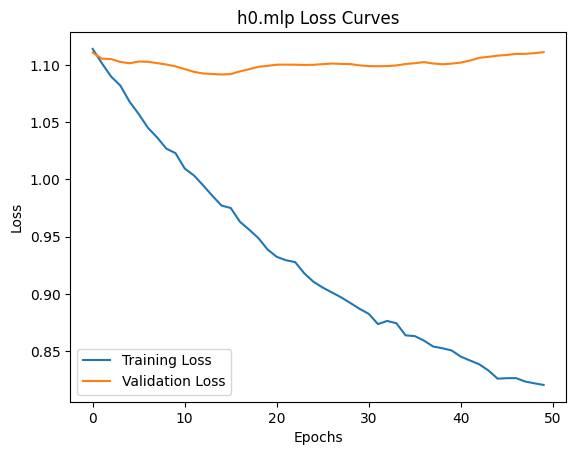

In [ ]:
if PROBING_LAYER == "h0.mlp" and PROMPT == "This conveys a similar message as this:":
  import matplotlib.pyplot as plt

  plt.plot(train_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.title('h0.mlp Loss Curves')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
if PROBING_LAYER == "h0.mlp" and PROMPT == "This conveys a similar message as this:":
  network.eval()  # Set the network to evaluation mode
  total_errors = 0
  total_samples = 0
  network.load_state_dict(torch.load(best_model_path))

  with torch.no_grad():
      for hidden_states, labels in test_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          # Forward pass
          outputs = network(input)

          # Get predictions from the maximum value
          _, predicted = torch.max(outputs.data, 1)
          print(predicted)

          total_errors += (predicted != target).sum().item()
          total_samples += target.size(0)

  error_rate = total_errors / total_samples

  print(f'h0.mlp Test Error Rate: {error_rate:.4f}')

tensor([1, 2, 1, 0], device='cuda:0')
tensor([2, 2, 1, 0], device='cuda:0')
tensor([1, 1, 2, 2], device='cuda:0')
tensor([0, 1, 0, 2], device='cuda:0')
tensor([1, 2, 0, 1], device='cuda:0')
tensor([1, 2, 1, 2], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([2, 2, 1, 1], device='cuda:0')
tensor([1, 2, 0, 1], device='cuda:0')
tensor([0, 2, 2, 1], device='cuda:0')
tensor([2, 2, 1, 0], device='cuda:0')
tensor([2, 2, 2, 0], device='cuda:0')
tensor([1, 2, 1, 0], device='cuda:0')
tensor([2, 1, 2, 0], device='cuda:0')
tensor([0, 1, 2, 1], device='cuda:0')
tensor([1, 1, 2, 2], device='cuda:0')
tensor([2, 0, 2, 1], device='cuda:0')
tensor([1, 2, 1, 1], device='cuda:0')
tensor([2, 1, 2], device='cuda:0')
h0.mlp Test Error Rate: 0.7467


###Layer.h.05.mlp


In [ ]:
if PROBING_LAYER == "h5.mlp" and PROMPT == "This conveys a similar message as this:":
  # Initialize the network, criterion, and optimizer as before

  train_losses, validation_losses = [], []
  best_val_loss = float('inf')
  best_model_path = 'best_model.pth'
  T = max_len
  network = CombinedNetwork(dm, num_classes)
  network.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = Adam(network.parameters(), lr=0.00001)
  for epoch in range(num_epochs):
      network.train()
      total_loss = 0
      total_val_loss = 0
      for hidden_states, labels in train_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          outputs = network(input)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_train_loss = total_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      network.eval()
      total_loss = 0
      with torch.no_grad():
          for hidden_states, labels in validation_loader:
              input = hidden_states.to(device)
              target = labels.to(device)
              outputs = network(input)
              loss = criterion(outputs, target)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(validation_loader)
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(network.state_dict(), best_model_path)

      validation_losses.append(avg_val_loss)

      print(f'h5.mlp Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

print(f'h5.mlp, best validation loss {best_val_loss}')

h5.mlp Epoch [1/50], Train Loss: 1.1094, Validation Loss: 1.1315
h5.mlp Epoch [2/50], Train Loss: 1.1014, Validation Loss: 1.1255
h5.mlp Epoch [3/50], Train Loss: 1.0859, Validation Loss: 1.1202
h5.mlp Epoch [4/50], Train Loss: 1.0777, Validation Loss: 1.1175
h5.mlp Epoch [5/50], Train Loss: 1.0619, Validation Loss: 1.1165
h5.mlp Epoch [6/50], Train Loss: 1.0552, Validation Loss: 1.1164
h5.mlp Epoch [7/50], Train Loss: 1.0474, Validation Loss: 1.1164
h5.mlp Epoch [8/50], Train Loss: 1.0383, Validation Loss: 1.1177
h5.mlp Epoch [9/50], Train Loss: 1.0329, Validation Loss: 1.1209
h5.mlp Epoch [10/50], Train Loss: 1.0232, Validation Loss: 1.1225
h5.mlp Epoch [11/50], Train Loss: 1.0126, Validation Loss: 1.1232
h5.mlp Epoch [12/50], Train Loss: 1.0135, Validation Loss: 1.1241
h5.mlp Epoch [13/50], Train Loss: 0.9993, Validation Loss: 1.1247
h5.mlp Epoch [14/50], Train Loss: 1.0017, Validation Loss: 1.1243
h5.mlp Epoch [15/50], Train Loss: 0.9885, Validation Loss: 1.1243
h5.mlp Epoch [16/50

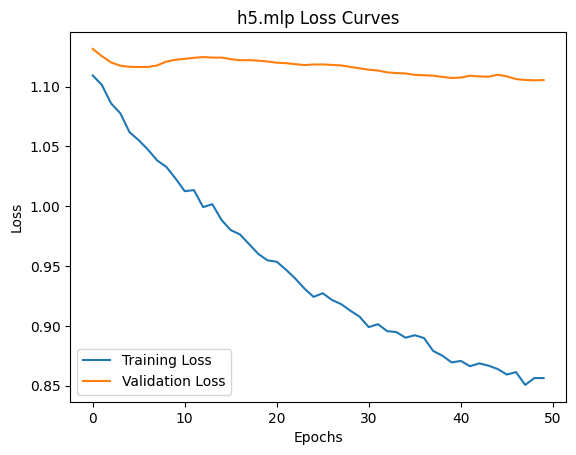

In [ ]:
if PROBING_LAYER == "h5.mlp" and PROMPT == "This conveys a similar message as this:":
  import matplotlib.pyplot as plt

  plt.plot(train_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.title('h5.mlp Loss Curves')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
if PROBING_LAYER == "h5.mlp" and PROMPT == "This conveys a similar message as this:":
  network.eval()  # Set the network to evaluation mode
  total_errors = 0
  total_samples = 0
  network.load_state_dict(torch.load(best_model_path))

  with torch.no_grad():
      for hidden_states, labels in test_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          # Forward pass
          outputs = network(input)

          # Get predictions from the maximum value
          _, predicted = torch.max(outputs.data, 1)
          print(predicted)

          total_errors += (predicted != target).sum().item()
          total_samples += target.size(0)

  error_rate = total_errors / total_samples

  print(f'h5.mlp Test Error Rate: {error_rate:.4f}')

tensor([1, 2, 0, 2], device='cuda:0')
tensor([2, 2, 1, 2], device='cuda:0')
tensor([0, 0, 2, 2], device='cuda:0')
tensor([2, 2, 1, 0], device='cuda:0')
tensor([2, 2, 1, 0], device='cuda:0')
tensor([1, 2, 0, 0], device='cuda:0')
tensor([2, 2, 0, 1], device='cuda:0')
tensor([0, 1, 2, 0], device='cuda:0')
tensor([2, 1, 2, 1], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([1, 0, 1, 2], device='cuda:0')
tensor([2, 2, 0, 2], device='cuda:0')
tensor([2, 1, 1, 1], device='cuda:0')
tensor([0, 1, 2, 1], device='cuda:0')
tensor([2, 0, 0, 2], device='cuda:0')
tensor([0, 2, 0, 0], device='cuda:0')
tensor([0, 0, 2, 0], device='cuda:0')
tensor([1, 2, 2, 1], device='cuda:0')
tensor([2, 0, 1], device='cuda:0')
h5.mlp Test Error Rate: 0.6400


### Layer h.09.mlp

In [ ]:
if PROBING_LAYER == "h9.mlp" and PROMPT == "This conveys a similar message as this:":
 # Initialize the network, criterion, and optimizer as before

  train_losses, validation_losses = [], []
  best_val_loss = float('inf')
  best_model_path = 'best_model.pth'
  T = max_len
  network = CombinedNetwork(dm, num_classes)
  network.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = Adam(network.parameters(), lr=0.00001)
  for epoch in range(num_epochs):
      network.train()
      total_loss = 0
      total_val_loss = 0
      for hidden_states, labels in train_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          outputs = network(input)
          loss = criterion(outputs, target)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_train_loss = total_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      network.eval()
      total_loss = 0
      with torch.no_grad():
          for hidden_states, labels in validation_loader:
              input = hidden_states.to(device)
              target = labels.to(device)
              outputs = network(input)
              loss = criterion(outputs, target)
              total_val_loss += loss.item()

      avg_val_loss = total_val_loss / len(validation_loader)
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(network.state_dict(), best_model_path)

      validation_losses.append(avg_val_loss)

      print(f'h9.mlp Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

print(f'h9.mlp, best validation loss {best_val_loss}')

h9.mlp Epoch [1/50], Train Loss: 1.0998, Validation Loss: 1.0973
h9.mlp Epoch [2/50], Train Loss: 1.0913, Validation Loss: 1.0958
h9.mlp Epoch [3/50], Train Loss: 1.0901, Validation Loss: 1.0936
h9.mlp Epoch [4/50], Train Loss: 1.0740, Validation Loss: 1.0916
h9.mlp Epoch [5/50], Train Loss: 1.0771, Validation Loss: 1.0918
h9.mlp Epoch [6/50], Train Loss: 1.0784, Validation Loss: 1.0930
h9.mlp Epoch [7/50], Train Loss: 1.0762, Validation Loss: 1.0937
h9.mlp Epoch [8/50], Train Loss: 1.0661, Validation Loss: 1.0938
h9.mlp Epoch [9/50], Train Loss: 1.0640, Validation Loss: 1.0943
h9.mlp Epoch [10/50], Train Loss: 1.0606, Validation Loss: 1.0939
h9.mlp Epoch [11/50], Train Loss: 1.0535, Validation Loss: 1.0926
h9.mlp Epoch [12/50], Train Loss: 1.0545, Validation Loss: 1.0910
h9.mlp Epoch [13/50], Train Loss: 1.0498, Validation Loss: 1.0888
h9.mlp Epoch [14/50], Train Loss: 1.0499, Validation Loss: 1.0858
h9.mlp Epoch [15/50], Train Loss: 1.0463, Validation Loss: 1.0839
h9.mlp Epoch [16/50

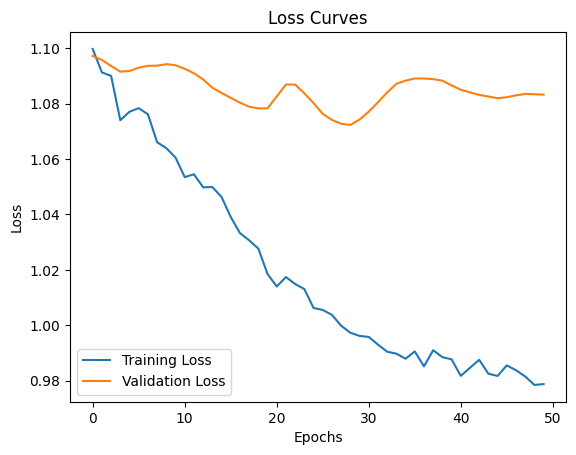

In [ ]:
if PROBING_LAYER == "h9.mlp" and PROMPT == "This conveys a similar message as this:":
  import matplotlib.pyplot as plt
  plt.plot(train_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.title('Loss Curves')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
if PROBING_LAYER == "h9.mlp" and PROMPT == "This conveys a similar message as this:":
  network.eval()  # Set the network to evaluation mode
  total_errors = 0
  total_samples = 0
  network.load_state_dict(torch.load(best_model_path))

  with torch.no_grad():
      for hidden_states, labels in test_loader:
          input = hidden_states.to(device)
          target = labels.to(device)
          # Forward pass
          outputs = network(input)

          # Get predictions from the maximum value
          _, predicted = torch.max(outputs.data, 1)
          print(predicted)

          total_errors += (predicted != target).sum().item()
          total_samples += target.size(0)

  error_rate = total_errors / total_samples

  print(f'h9.mlp Test Error Rate: {error_rate:.4f}')

tensor([2, 0, 2, 2], device='cuda:0')
tensor([2, 0, 2, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 2, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 2, 2, 0], device='cuda:0')
tensor([0, 0, 2, 1], device='cuda:0')
tensor([0, 2, 0, 1], device='cuda:0')
tensor([0, 2, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([2, 0, 2, 2], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([0, 1, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 1], device='cuda:0')
tensor([0, 1, 0, 2], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0], device='cuda:0')
h9.mlp Test Error Rate: 0.6533
